Integrated Current [C]: 0.00036329941799999993
Particles: 226778662921348.25 

Linear Fit: -0.07556875215414274x + 258.32963612903217 

Chi-Square Value: 3587.429643920986
R^2 Value: 0.25649245174911917
Exponential Fit:  91.46927715207111e^(-0.0003321973319528524*(t-3035.986213147655))
Chi-squared Value: 3971.118414512096
R^2 Value: 0.20548094055335886


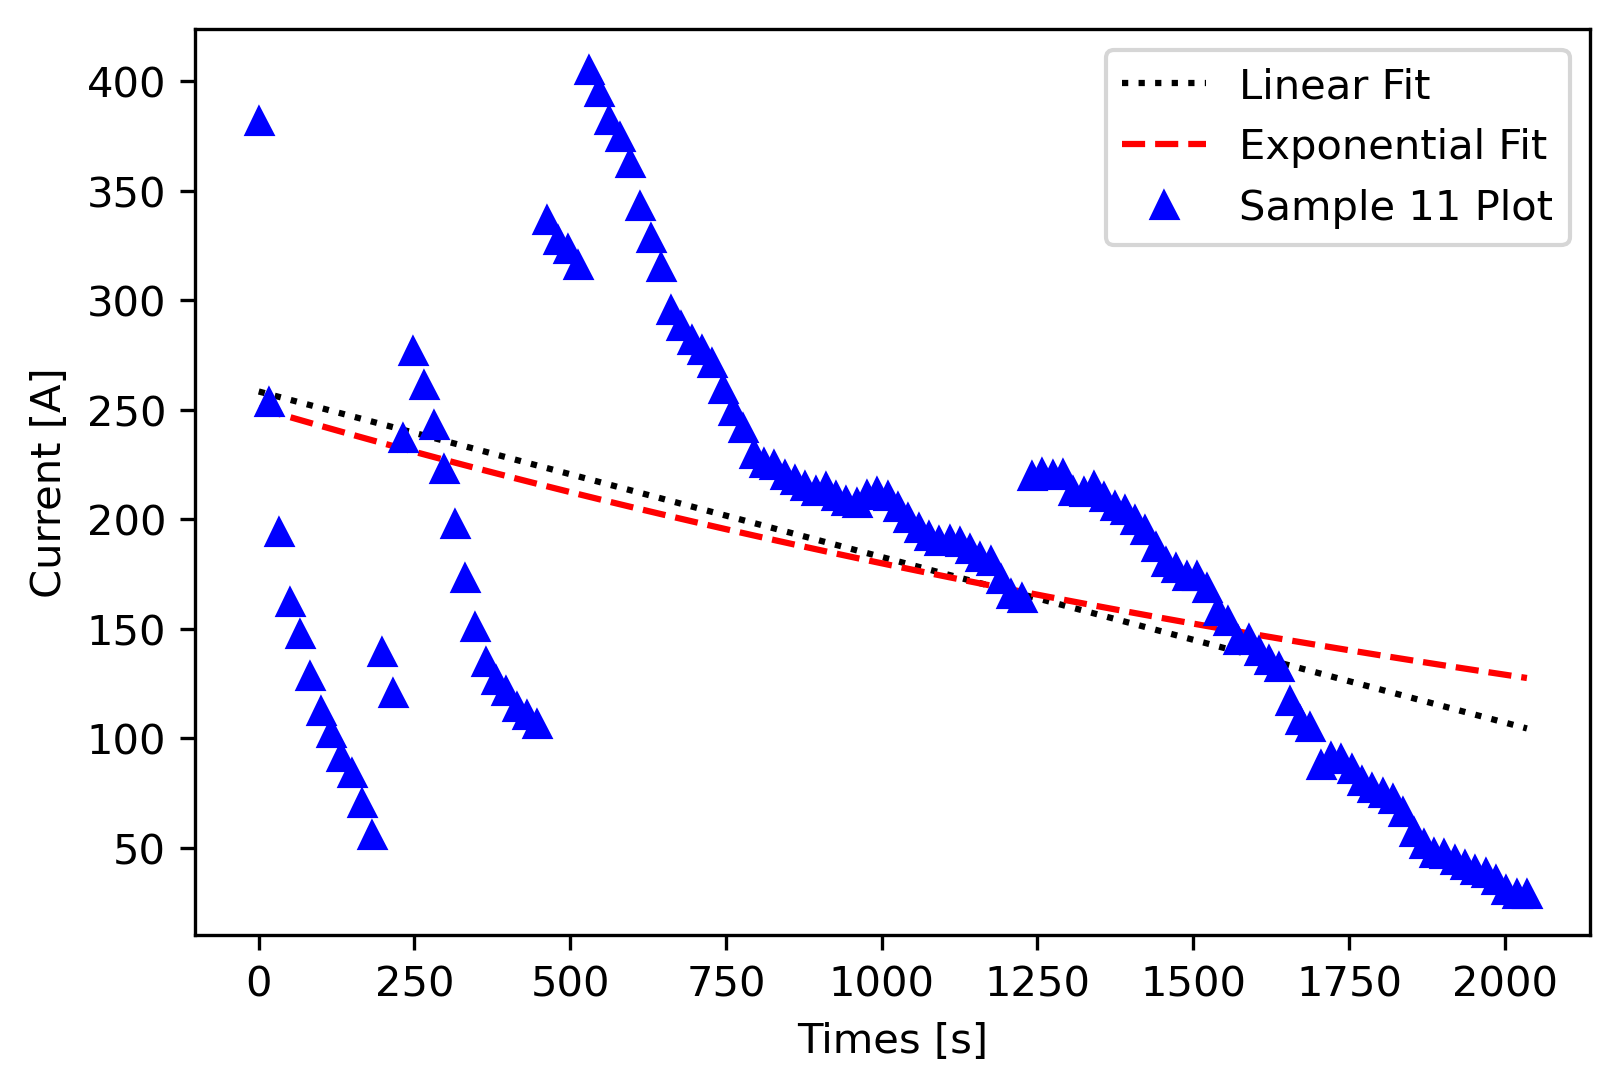

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chisquare
import scipy.optimize
from scipy.stats import chisquare

def results(file, plotlabel, scale, run=1, tunings=[], changes=[], 
            # Fitting 
            lin=False, exp=False, 
            # Customisation
            fmt="", title="", xax="", yax="", xlim=(), ylim=(), spines=[]):
    
    # Get results based on run. Initial run value is 1 as some files have more than 1 run
    def get_results(file, run):
        output = np.loadtxt(file, delimiter=',', dtype=str)
        if (len(output) < 67):
            # Files C26_1 and C27_1 both stop before a whole measurement is complete. 
            if ((file == "M727_C26_1.txt") or (file == "M727_C27_1.txt")):
                results = [output[i].split() for i in range(len(output))][4:35]
            else:
                results = [output[i].split() for i in range(len(output))][4:]
        else:
            if run==1:
                results = [output[i].split() for i in range(len(output))][4:66]
            elif run==2:
                results = [output[i].split() for i in range(len(output))][70:]
            else:
                raise Exception("Invalid input: runs must be 1 or 2")
        for i in range(len(results)):
            for j in range(len(results[i])):
                results[i][j] = float(results[i][j])
        return results
    results = get_results(file, run)
    
    # Remove the tuning loops used to optimize the current
    def remove_tunings(results, lst=[]):
        if len(lst) > 0:
            lst, loops = list(map(float, lst)), list(map(float, range(1, len(results)+1)))
            new_loops = [x for x in loops if x not in lst]
            output = []
            for i in range(len(results)):
                if results[i][0] in new_loops:
                    output.append(results[i])
            results = output
            return results
        else:
            return results 
    results = remove_tunings(results, tunings)
    
    #Initialise values for partition function, which splits list into sub-lists
    if len(changes) > 0:
        loops, scales = zip(*changes)
        loops = list(loops)
        scales = list(scales)
    else:
        loops = []
        scales = []
    
    # Partition function to apply current transformations
    def partition(results, loops=[]):
        if len(loops) > 0:
            original = results.copy()
            temp = []
            p_list = []
            for j in range(len(loops)):
                for i in range(len(results)):
                    if loops[j] > results[i][0]:
                        temp.append(results[i])
                p_list.append(temp)
                # added to the partition values are truncated from the list
                results = results[len(temp):]
                temp = []
            truncated = [original[loops[-1]-1:]]
            results = p_list + truncated
            return results
        else:
            return results
    results = partition(results, loops)
    
    # Map current transformsations to partitions
    def currents(results, scale, scales=[]):
        if len(scales) > 0:
            # Combine partition and scales
            scales = [scale] + scales 
            transforms = list(zip(results, scales))
            for i in range(len(transforms)):
                    for j in range(len(transforms[i][0])):
                        transforms[i][0][j][1] = transforms[i][0][j][1] * transforms[i][1]/10000
                        transforms[i][0][j][2] = transforms[i][0][j][2] * transforms[i][1]/10000

            # Re-split them back
            unzipped_list, scales = zip(*transforms)
            unzipped_list = list(unzipped_list)
            final = []
            for i in range(len(unzipped_list)):
                final = final + unzipped_list[i]
            results = final
            return results
        else:
            for i in range(len(results)):
                results[i][1] = results[i][1] * scale/10000
                results[i][2] = results[i][2] * scale/10000
            return results
    results = currents(results, scale, scales) 
    
    # Grab results for the dataset
    def data_points(results):
        dataset = []
        for i in range(len(results)):
            dataset.append(results[i][1])
            dataset.append(results[i][2])
        return dataset # Complexity: O(n)

    dataset = data_points(results)
    times = []
    for i in range(0,len(dataset)):
        times.append(i*16.55)
    
    # Calculate coloumbs measured
    def values(dataset):
        const_charge = 1.602 * 10e-19
        area = sum(dataset) * 32.3/2 * (10 ** -9)
        particles = area/const_charge
        return (area, particles)
    
    area, particles = values(dataset)[0], values(dataset)[1]
    print(f"Integrated Current [C]: {area}")
    print(f"Particles: {particles} \n")
    
    # Statistics 
    
    # Calculates R^2 Value
    def r2val(fit, dataset):
        av = sum(dataset)/len(dataset)
        denom, num = 0, 0
        for i in range(len(dataset)):
            num += (dataset[i] - fit[i]) ** 2
        for i in range(len(dataset)):
            denom += (dataset[i] - av) ** 2
        output = 1 - (num/denom)
        return output
    
    # Linear Fitting
    if lin:
        m, b = np.polyfit(times, dataset, 1, full=False)
        lin_fit = m*np.array(times) + b
        chi_lin = chisquare(np.array(dataset), lin_fit)
        r2_lin = r2val(lin_fit, dataset)
        print(f"Linear Fit: {m}x + {b} \n")
        print(f"Chi-Square Value: {chi_lin[0]}")
        print(f"R^2 Value: {r2_lin}")
        plt.plot(times, lin_fit, 'k:', label="Linear Fit")
    
    # Exponential Fitting 
    def monoExp(t, a, b, c):
        return a * np.exp(b*(t-c))
    if exp:
        p1, p2 = scipy.optimize.curve_fit(monoExp, times, dataset, 
                                          p0 = [30, -0.001, 2000], # the initial guess that optimizes the fit
                                          maxfev=30000) # increases no. of iterations to find maximal parameters
        exp_fit = monoExp(np.array(times), *p1)
        chi_exp = chisquare(np.array(dataset), exp_fit)
        r2_exp = r2val(exp_fit, dataset)
        print("Exponential Fit:  {0}e^({1}*(t-{2}))".format(*p1))
        print(f"Chi-squared Value: {chi_exp[0]}")
        print(f"R^2 Value: {r2_exp}")
        plt.plot(times, exp_fit, 'r--', label='Exponential Fit')
    
    plt.title(title)
    plt.xlabel(xax)
    plt.ylabel(yax)
    
    # Change axis lengths
    if len(xlim) == 0:
        pass
    elif len(xlim) == 2: 
        plt.xlim(left=xlim[0],right=xlim[1])
    else: 
        raise Exception("Enter a valid range of two arguements only")
    if len(ylim) == 0:
        pass
    elif len(ylim) == 2: 
        plt.ylim(bottom=ylim[0],top=ylim[1])
    else: 
        raise Exception("Enter a valid range of two arguements only")
        
    # Configure Spines
    if len(spines) == 0:
        pass
    for i in spines:
        plt.gca().spines[i].set_visible(False)

    # Return Final Graph
    if len(fmt) == 0:
        return plt.plot(times, dataset, 'k.', label=plotlabel)
    else:
        return plt.plot(times, dataset, fmt, label=plotlabel)

plt.figure(dpi=300) # Change figure resolution
results("M727_C13_1.txt", 'Sample 11 Plot', 600,2,
        lin=True, exp=True,
        fmt='b^', title="", xax="Times [s]", yax="Current [A]")
plt.legend() 
plt.show()